In [22]:
from dataset import TranSiGenDataset
from model import TranSiGen
from utils import *
import pickle
import argparse
import warnings
import torch
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
dev = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Carregamento dos dados

Os dados são carregados a partir de um arquivo `.h5`:

In [4]:
data_path = '../data/LINCS2020/data_example/processed_data_id.h5'

In [5]:
data = load_from_HDF(data_path)

O conteúdo do arquivo é um dicionário contendo as seguintes informações:

In [6]:
print(", ".join(data.keys()))

LINCS_index, canonical_smiles, cid, sig


- **LINCS_index**: 
- **canonical_smiles**: ids das moléculas dos compostos químicos. Esse id é convertido para o padrão Smiles usando o vetor `idx2smi` definido posteriormente.
- **cid**: cell line identifier
- **sig**: signature

Esse conjunto é, em resumo, um ponteiro para os dados. Os dados em si serão carregados mais à frente pela classe `TranSiGenDataset`.

## Definição das configurações gerais
Observações:
- `cell_count`: número de linhagens celulares. Usado apenas para identificar o modelo salvo.
- `feat_type`: tipo de representação das moléculas. Para o uso no modelo, o código Smiles é convertido para uma outra representação da molécula. Essa conversão pode ser feita tanto para um embedding pelo modelo pré-treinado KPGT, ou pela impressão digital molecular (*molecular fingerprint*) ECFP4.
- `split_type`: define como os dados serão dividos em treino, validação e teste. Os possíveis valores são
    - `random_split`: essa divisão é feita de forma aleatória.
    - `cell_split`: os conjuntos são dividos considerando uma mesma linhagem celular, para que não haja o risco de todos os dados de uma célula (ou boa parte deles) fiquem apenas em um dos conjuntos.
- `features_dim`: tamanho do vetor que representa a molécula. No caso do KPGT, esse valor é 2304. No caso do ECFP4, o valor é 2048.

In [8]:
cell_count = len(set(data['cid']))
feat_type = 'KPGT'
batch_size = 64
learning_rate = 1e-3
beta = 0.1
dropout = 0.1
weight_decay = 1e-5
n_folds = 5
random_seed = 364039
split_type = 'smiles_split'
features_dim = 2304
features_embed_dim = [400]
n_latent = 100
# init_mode = 'pretrain_shRNA'
init_mode = 'random'
n_epochs = 300
molecule_path = '../data/LINCS2020/idx2smi.pickle'

In [9]:
local_out = '../results/trained_models_{}_cell_{}/{}/feature_{}_init_{}/'.format(cell_count, split_type, random_seed, feat_type, init_mode)

Abaixo é carregador o vetor `idx2smi`, responsável por converter os índices das moléculas carregadas acima nos respectivos códigos Smiles.

In [10]:
with open(molecule_path, 'rb') as f:
    idx2smi = pickle.load(f)

Exemplo:

In [11]:
idx2smi[2]

np.str_('BrCC(=O)NCCc1ccc2ccccc2c1')

## Divisão de treino e teste

In [12]:
pair, pairv, pairt = split_data(data, n_folds=n_folds, split_type=split_type, rnds=random_seed)

In [13]:
train = TranSiGenDataset(
    LINCS_index=pair['LINCS_index'],
    mol_feature_type=feat_type,
    mol_id=pair['canonical_smiles'],
    cid=pair['cid']
)

valid = TranSiGenDataset(
    LINCS_index=pairv['LINCS_index'],
    mol_feature_type=feat_type,
    mol_id=pairv['canonical_smiles'],
    cid=pairv['cid']
)

test = TranSiGenDataset(
    LINCS_index=pairt['LINCS_index'],
    mol_feature_type=feat_type,
    mol_id=pairt['canonical_smiles'],
    cid=pairt['cid']
)

train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=4, worker_init_fn=seed_worker)
valid_loader = torch.utils.data.DataLoader(dataset=valid, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=4, worker_init_fn=seed_worker)
test_loader = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=4, worker_init_fn=seed_worker)

## Criação do Modelo

In [14]:
model = TranSiGen(
    n_genes=978,
    n_latent=n_latent,
    n_en_hidden=[1200],
    n_de_hidden=[800],
    features_dim=features_dim,
    features_embed_dim=features_embed_dim,
    init_w=True,
    beta=beta,
    device=dev,
    dropout=dropout,
    path_model=local_out,
    random_seed=random_seed
)

In [15]:
_ = model.to(dev)

### Arquitetura do Modelo
Arquitetura dos codificadores do $X_1$ e do $X_2$ (são iguais):

In [16]:
model.encoder_x1

Sequential(
  (0): Linear(in_features=978, out_features=1200, bias=True)
  (1): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.1, inplace=False)
)

Arquitetura dos decodificadores do $X_1$ e do $X_2$ (também são iguais):

In [17]:
model.decoder_x2

Sequential(
  (0): Linear(in_features=100, out_features=800, bias=True)
  (1): BatchNorm1d(800, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.1, inplace=False)
  (4): Linear(in_features=800, out_features=978, bias=True)
  (5): ReLU()
)

Arquitetura do embedder da molécula:

In [18]:
model.feat_embeddings

Sequential(
  (0): Linear(in_features=2304, out_features=400, bias=True)
  (1): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): Dropout(p=0.1, inplace=False)
)

## Treinamento/Carregamento do Modelo

In [19]:
if init_mode == 'pretrain_shRNA':
    # Carregando modelo pré-treinado
    print('=====load vae for x1 and x2=======')
    model_dict = model.state_dict()
    filename = '../results/trained_model_shRNA_vae_x1/best_model.pt'
    model_base_x1 = torch.load(filename, map_location='cpu')
    model_base_x1_dict = model_base_x1.state_dict()
    for k in model_dict.keys():
        if k in model_base_x1_dict.keys():
            model_dict[k] = model_base_x1_dict[k]
    filename = '../results/trained_model_shRNA_vae_x2/best_model.pt'
    model_base_x2 = torch.load(filename, map_location='cpu')
    model_base_x2_dict = model_base_x2.state_dict()
    for k in model_dict.keys():
        if k in model_base_x2_dict.keys():
            model_dict[k] = model_base_x2_dict[k]
    model.load_state_dict(model_dict)
    del model_base_x1, model_base_x2
else:
    epoch_hist, best_epoch = model.train_model(
        train_loader=train_loader,
        test_loader=valid_loader,
        n_epochs=n_epochs,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        save_model=False
    )

[Epoch 0] | loss: nan, mse_x1_rec: 459314212.800, mse_x2_rec: 7854869063.631, mse_pert: nan, kld_x1: 221337078.031, kld_x2: 5006774685.538, kld_pert: inf| valid_loss: nan, valid_mse_x1_rec: 560218396.444, valid_mse_x2_rec: 4298526264.889, valid_mse_pert: nan, valid_kld_x1: 244721408.000, valid_kld_x2: 5519151104.000, valid_kld_pert: inf|
[Epoch 1] | loss: nan, mse_x1_rec: 405455531.323, mse_x2_rec: 3450501243.569, mse_pert: nan, kld_x1: 115661712.677, kld_x2: 1049223889.046, kld_pert: inf| valid_loss: nan, valid_mse_x1_rec: 975793265.778, valid_mse_x2_rec: 3123835562.667, valid_mse_pert: nan, valid_kld_x1: 204613575.111, valid_kld_x2: 1301032163.556, valid_kld_pert: inf|
[Epoch 2] | loss: nan, mse_x1_rec: 28536332.862, mse_x2_rec: 24173037.538, mse_pert: nan, kld_x1: 4504655.508, kld_x2: 4947953.748, kld_pert: inf| valid_loss: nan, valid_mse_x1_rec: 72727232.000, valid_mse_x2_rec: 122179783.111, valid_mse_pert: nan, valid_kld_x1: 5535900.889, valid_kld_x2: 9418337.778, valid_kld_pert: 

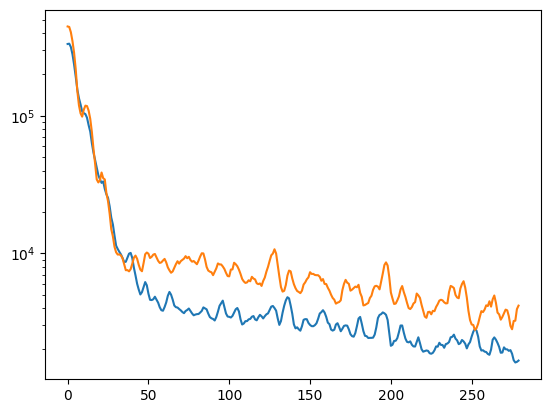

In [28]:
plt.plot(epoch_hist['train_loss'][20:])
plt.plot(epoch_hist['valid_loss'][20:])
plt.yscale('log')

## Avaliação do Modelo no Conjunto Teste

In [29]:
_, _, test_metrics_dict_ls = model.test_model(loader=test_loader, metrics_func=['pearson', 'rmse', 'precision100'])

for name, rec_dict_value in zip(['test'], [test_metrics_dict_ls]):
    df_rec = pd.DataFrame.from_dict(rec_dict_value)
    smi_ls = []
    for smi_id in df_rec['cp_id']:
        smi_ls.append(idx2smi[smi_id])
    df_rec['canonical_smiles'] = smi_ls

In [30]:
_, _, test_metrics_dict_ls = model.test_model(loader=test_loader, metrics_func=['pearson', 'rmse', 'precision100'])


In [31]:
df_rec

,x1_rec_pearson,x1_rec_rmse,x1_rec_neg_precision100,x1_rec_pos_precision100,x2_rec_pearson,x2_rec_rmse,x2_rec_neg_precision100,x2_rec_pos_precision100,x2_pred_pearson,x2_pred_rmse,...,DEG_rec_neg_precision100,DEG_rec_pos_precision100,DEG_pred_pearson,DEG_pred_rmse,DEG_pred_neg_precision100,DEG_pred_pos_precision100,cp_id,cid,sig,canonical_smiles
0,0.969432,0.949407,0.83,0.80,0.970095,1.560071,0.77,0.80,0.957157,1.846240,...,0.32,0.19,0.203525,1.846240,0.24,0.12,6,MCF7,MCF7_6,Brc1c[nH]c2nc(SCc3ccccc3C#N)nc2c1
1,0.905922,1.879267,0.71,0.71,0.949290,1.693429,0.84,0.81,0.946227,2.758447,...,0.22,0.57,0.510613,2.758447,0.16,0.52,9,VCAP,VCAP_9,Brc1ccc(CSc2nnc(c3ccccn3)n2Cc4ccco4)cc1
2,0.956333,0.952491,0.84,0.80,0.943994,1.225090,0.74,0.82,0.936022,2.462712,...,0.17,0.23,0.259415,2.462712,0.15,0.20,6,HA1E,HA1E_6,Brc1c[nH]c2nc(SCc3ccccc3C#N)nc2c1
3,0.969782,0.693343,0.83,0.83,0.947805,0.713183,0.80,0.75,0.943905,0.772976,...,0.27,0.38,0.527494,0.772976,0.24,0.37,13,ASC,ASC_13,Brc1ccc(NC(=O)N2NC(=O)[C@H]([C@@H]2c2ccccc2)c2...
4,0.937173,2.433898,0.75,0.78,0.918985,2.281820,0.72,0.77,0.909061,3.124938,...,0.14,0.17,0.147774,3.124938,0.07,0.14,6,A375,A375_6,Brc1c[nH]c2nc(SCc3ccccc3C#N)nc2c1
5,0.858721,3.612365,0.65,0.61,0.849311,3.860855,0.61,0.66,0.863057,3.562009,...,0.10,0.21,0.174724,3.562009,0.10,0.18,6,HT29,HT29_6,Brc1c[nH]c2nc(SCc3ccccc3C#N)nc2c1
6,0.858466,3.716474,0.64,0.62,0.844875,3.671752,0.68,0.67,0.837919,4.622357,...,0.19,0.14,0.171790,4.622357,0.18,0.15,9,HT29,HT29_9,Brc1ccc(CSc2nnc(c3ccccn3)n2Cc4ccco4)cc1
7,0.968808,1.192924,0.88,0.78,0.958100,1.722698,0.82,0.77,0.945335,1.927860,...,0.13,0.12,0.013325,1.927860,0.11,0.12,6,PC3,PC3_6,Brc1c[nH]c2nc(SCc3ccccc3C#N)nc2c1
8,0.937494,1.356717,0.76,0.81,0.959954,0.710650,0.80,0.83,0.953142,1.889974,...,0.36,0.45,0.462031,1.889974,0.24,0.32,13,A549,A549_13,Brc1ccc(NC(=O)N2NC(=O)[C@H]([C@@H]2c2ccccc2)c2...
9,0.967540,0.581544,0.83,0.85,0.945041,0.809833,0.81,0.81,0.934802,1.331315,...,0.29,0.28,0.238136,1.331315,0.19,0.16,9,PC3,PC3_9,Brc1ccc(CSc2nnc(c3ccccn3)n2Cc4ccco4)cc1
